# Reconocimiento de digitos

## Este cuaderno esta realizado con jupyter notebook el 5 de Frebrero del 2024 y la información esta actualizada hasta el 2012

### El cuaderno esta realizado por José de Jesús Hernández Vázquez

#### Los conjuntos de datos estan todos en kaggle.omc con el siguiente link: https://www.kaggle.com/competitions/digit-recognizer/data

#### Para este cuadernillo vamos a realizar lo siguiente:
1. Preprocesamiento de datos
2. Definición del modelo 
3. Entrenamiento del modelo
4. Evaluación del modelo
5. Predicción y generación del archivo de envío
6. Iteración y ajuste del modelo

### Vamos a hacer las importaciones necesarias para poder realizar este proyecto


In [201]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Cargamos el conjunto de datos de prueba

In [202]:
df = pd.read_csv('./assets/test.csv')

df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Cargamos el conjunto de datos de entrenamiento

In [203]:
df_train = pd.read_csv('./assets/train.csv')

df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Cargamos el conjunto de datos que da como ejemplo a la hora de subir nuestro archivo

In [204]:
df_sample = pd.read_csv('./assets/sample_submission.csv')

df_sample

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


# Preprocesamiento de datos

### Dividimos el conjunto de datos de entrenamiento en conjuntos de entrenamiento y validación para evaluar el rendimiento del modelo.

In [205]:
df_train, val_df = train_test_split(df_train, test_size=0.2, random_state=42)

### Definimos una clase personalizada que herede de torch.utils.data.Dataset para cargar los datos en PyTorch.

In [206]:

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape((28, 28))
        label = torch.tensor(self.data.iloc[idx, 0], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

### Definimos transformaciones de datos, como normalización, utilizando torchvision.transforms.

In [207]:

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


## Verificación de los datos

### Antes de continuar con el paso 2 que es la definición del modelo, debemos asegurarnos que todo vaya a funcionar como lo esperamos

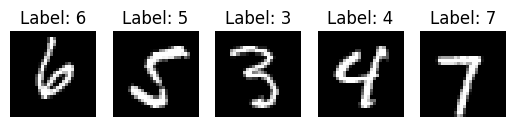

In [208]:
# Visualización de algunas imágenes de entrenamiento


for i in range(5):
    image, label = CustomDataset(df_train, transform=data_transform)[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label.item()}')
    plt.axis('off')

plt.show()

#### Como podemos observar en la visualización, los digitos si corresponden totalmente a su etiqueta

### Procederemos a cargar los datos en lotes

In [209]:
train_loader = DataLoader(CustomDataset(df_train, transform=data_transform), batch_size=64, shuffle=True)
val_loader = DataLoader(CustomDataset(val_df, transform=data_transform), batch_size=64, shuffle=False)
test_loader = DataLoader(CustomDataset(df, transform=data_transform), batch_size=64, shuffle=False)


### Verificamos que los datos si tengan las dimensiones correctas

In [210]:
for images, labels in train_loader:
    print(f'Batch Shape - Images: {images.shape}, Labels: {labels.shape}')
    break


Batch Shape - Images: torch.Size([64, 1, 28, 28]), Labels: torch.Size([64])


#### Este código imprimirá las formas (dimensiones) de un lote de imágenes y etiquetas. Aquí hay algunas cosas a considerar:

* Imágenes: Si estás utilizando imágenes en escala de grises de 28x28 píxeles, las dimensiones de cada imagen deberían ser (batch_size, 1, 28, 28). La dimensión 1 indica que es una imagen en escala de grises.

* Etiquetas: La dimensión de las etiquetas dependerá de cómo hayas representado tus etiquetas. Si estás usando etiquetas como enteros, deberían tener una forma de (batch_size,). Si estás utilizando one-hot encoding, entonces la dimensión de las etiquetas podría ser (batch_size, num_classes).

# Definición del modelo

In [211]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 clases para los dígitos (0-9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Este es un modelo de red neuronal convolucional (CNN) bastante simple. Aquí hay una breve descripción de las capas:

* Conv2d: Capas convolucionales para extraer características de las imágenes.
* MaxPool2d: Capas de agrupación para reducir las dimensiones espaciales.
* Linear: Capas totalmente conectadas para la clasificación final.

#### Antes de continuar con el entrenamiento del modelo, debemos asegurarnos de tener un optimizador y poder calcular nuestra funcion de perdida, aparte de definir el dispositivo en el cual estamos corriendo el modelo

In [212]:
# Definir el modelo
model = SimpleCNN()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Mover el modelo a dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Mover las imágenes y etiquetas a la GPU
images, labels = images.to(device), labels.to(device)

In [213]:
# class TrainDataset(Dataset):
#     def __init__(self, data):
#         self.data = data

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         image_row = self.data.iloc[idx, 1:].values.astype(np.uint8)
#         image = image_row.reshape((28, 28))  # Cambiar la forma a (28, 28)
#         image = image / 255.0  # Escalar los valores de píxeles al rango [0, 1]

#         label = torch.tensor(self.data.iloc[idx, 0], dtype=torch.long)

#         return torch.unsqueeze(torch.tensor(image, dtype=torch.float32), 0), label


# Entrenamiento del modelo

In [214]:
# Número de épocas (iteraciones completas a través del conjunto de entrenamiento)
num_epochs = 5

# Bucle de entrenamiento
for epoch in range(num_epochs):
    # Modo de entrenamiento
    model.train()
    
    # Bucle a través de los lotes de entrenamiento
    for images, labels in train_loader:
        # Mover los datos al dispositivo
        images, labels = images.to(device), labels.to(device)
        
        # Reiniciar los gradientes acumulados en cada iteración
        optimizer.zero_grad()
        
        # Pasar las imágenes a través del modelo
        outputs = model(images)
        
        # Calcular la pérdida
        loss = criterion(outputs, labels)
        
        # Retropropagación y optimización
        loss.backward()
        optimizer.step()

    # Imprimir la pérdida promedio en cada época
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Asegurarse de que el modelo esté en modo de evaluación para la evaluación
model.eval()


Epoch [1/5], Loss: 0.11388178914785385
Epoch [2/5], Loss: 0.057795196771621704
Epoch [3/5], Loss: 0.12699003517627716
Epoch [4/5], Loss: 0.18715344369411469
Epoch [5/5], Loss: 0.0013163033872842789


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### Este bucle de entrenamiento pasa por varias épocas, donde cada época consiste en iteraciones a través de los lotes de entrenamiento. En cada iteración, se realiza el siguiente flujo:

1. Mover los datos al dispositivo (CPU o GPU).
2. Reiniciar los gradientes acumulados en cada iteración.
3. Pasar las imágenes a través del modelo para obtener las predicciones.
4. Calcular la pérdida comparando las predicciones con las etiquetas reales.
5. Realizar la retropropagación del error y optimizar los pesos del modelo.
6. Imprimir la pérdida promedio al final de cada época.

### Haremos una visualización de los resultados unicamente con el fin de tener una idea gráfica de como esta funcionando el modelo

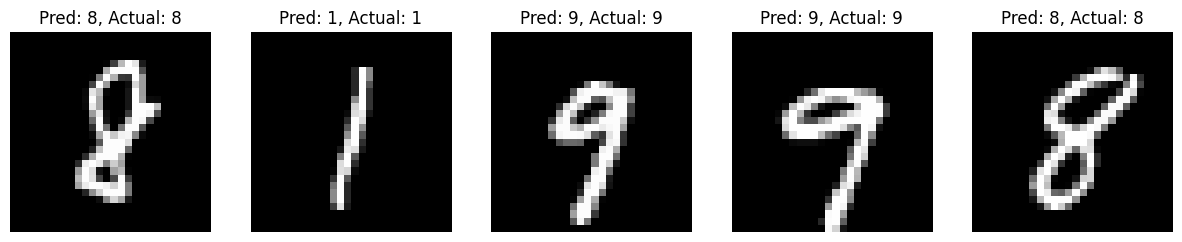

In [215]:
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Ajustar el tamaño de la figura
        plt.figure(figsize=(15, 3))
        
        # Visualizar algunas predicciones
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(images[i].cpu().numpy().squeeze(), cmap='gray')
            plt.title(f'Pred: {predicted[i]}, Actual: {labels[i].item()}')
            plt.axis('off')

        plt.show()
        break


### Como podemos visualizar el modelo esta haciendo buenas predicciones con respecto a lo que hay actualmente

# Evaluación del modelo

### Aquí evaluaremos el modelo en el conjunto de validación y vamos a realizar predicciones en el conjunto de prueba.

In [216]:
model.eval()  # Asegurarse de que el modelo esté en modo de evaluación

# Evaluar en el conjunto de validación
correct_val, total_val = 0, 0

with torch.no_grad():
    for images_val, labels_val in val_loader:
        images_val, labels_val = images_val.to(device), labels_val.to(device)
        outputs_val = model(images_val)
        _, predicted_val = torch.max(outputs_val, 1)
        total_val += labels_val.size(0)
        correct_val += (predicted_val == labels_val).sum().item()

validation_accuracy = correct_val / total_val
print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

Validation Accuracy: 98.90%


### Como podemos ver nuestro modelo tiene una precisión del 98.86%

### Vamos a proceder a hacer algunas predicciones en el conjunto de prueba

In [224]:
batch_size = 64

class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_row = self.data.iloc[idx, :].values.astype(np.uint8)  # Asegúrate de incluir todas las columnas
        image = image_row.reshape((1, 28, 28))  # Cambiar la forma a (1, 28, 28)
        image = image / 255.0  # Escalar los valores de píxeles al rango [0, 1]

        return torch.tensor(image, dtype=torch.float32)

# Crear el conjunto de prueba
test_dataset = TestDataset(df)  # Usa df_test en lugar de df_train

# Crear el cargador de datos para el conjunto de prueba
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [227]:
model.eval()

predictions = []

with torch.no_grad():
    for images_test in test_loader:
        images_test = images_test.to(device)
        outputs_test = model(images_test)
        _, predicted_test = torch.max(outputs_test, 1)
        predictions.extend(predicted_test.cpu().numpy())

# Verificar la longitud de predictions
print("Número de predicciones:", len(predictions))

# Crear el archivo de envío
submission_df = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission_df.to_csv('submission.csv', index=False)


Número de predicciones: 28000


In [226]:
# Verificar algunas predicciones en el conjunto de prueba
for i in range(5):
    print(f"Image {i+1}: Predicted Label {predictions[i]}")


Image 1: Predicted Label 2
Image 2: Predicted Label 0
Image 3: Predicted Label 9
Image 4: Predicted Label 8
Image 5: Predicted Label 3


#### Guardamos el modelo

In [228]:
torch.save(model.state_dict(), 'simple_cnn_model.pth')

# Conclusión

#### En este proceso, exploramos la implementación de un modelo de clasificación de dígitos escritos a mano utilizando PyTorch. Aprendimos a cargar y preprocesar conjuntos de datos, diseñar una red neuronal convolucional simple, entrenar el modelo y generar predicciones en un conjunto de prueba. Se abordaron desafíos como la manipulación de datos tabulares, la configuración del modelo y la gestión de dimensiones en las imágenes. Además, comprendimos la importancia de visualizar predicciones para evaluar el rendimiento del modelo. Este ejercicio proporcionó una valiosa experiencia en el flujo de trabajo de implementación de modelos de aprendizaje profundo y la aplicación práctica de conceptos fundamentales en visión por computadora.